#### https://online.stat.psu.edu/stat510/lesson/9

**Tranfer function models** <br>
We model $y_t$ as potentially a function of past lags of $y_t$ and current and past lags of the x-variables. 

One difficulty is that the CCF is affected by the time series structure of the x-variable and any "in common" trends the x and y series may shareover time.

One strategy for dealing with this difficulty is "pre-whitening". The steps are:
<ol>
    <li>Fit TS model of x variables, and store the residuals</li>
    <li>Filter the y series using the model from step 1. In this step we find differences between observed y-values nad estimated y-values.</li>
    <li>Examine the CCF between the residuals from step1 and the filtered y-values from step 2. This CCF can be used to identify the possible terms for a lagged regression.</li>
</ol>

In essence, pre-whitening is just used to help identify which lags of x may predict y.

Example: {$x_t$} is ARIMA(1,1,0) process with $\phi_1=0.7$ and the error variance was 1. The sample size was n = 200. Simulate $y_t = 15 + 0.8 x_{t-3} + 1.5 x_{t-4}$. We skip adding random error into y.

In [1]:
import pandas as pd 
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.metrics import mean_squared_error
from IPython.display import Image
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

#### simulate ARIMA(1,1,0) where $\phi = 0.7$ and the error variance is 1

Recall the general formula is:
$$
(1 - \sum_{i=1}^p \phi_i B^i) (1-B)^d x_t = (1+ \sum_{i=1}^q \theta_i B^i) \epsilon_t
$$

For ARIMA(1,1,0), it is
$$
(1-0.7B)(1-B)x_t = \epsilon_t
$$

$$
x_t = 1.7 x_{t-1} - 0.7 x_{t-2} + \epsilon_t
$$

In [42]:
x_arr = np.zeros(201)
x_error_arr = np.random.normal(scale=1, size=201)
for i in range(2, 201):
    x_arr[i] = x_arr[i-1] * 1.7 - x_arr[i-2] * 0.7 + x_error_arr[i]

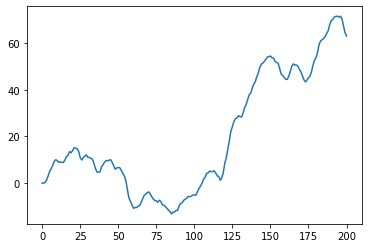

In [44]:
plt.plot(x_arr)

In [45]:
y_arr = np.zeros(201)
for i in range(4,201):
    y_arr[i] = 15 + 0.8 * x_arr[i-3] + 1.5 * x_arr[i-4]

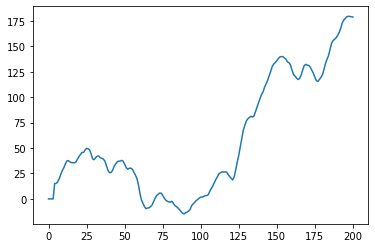

In [46]:
plt.plot(y_arr)

<AxesSubplot:>

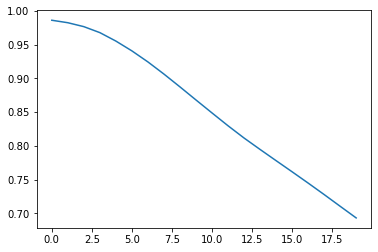

In [47]:
pd.Series(sm.tsa.stattools.ccf(x=y_arr, y=x_arr, adjusted=False)[:20]).plot()

#### step1: Fit ARIMA model for the x-series

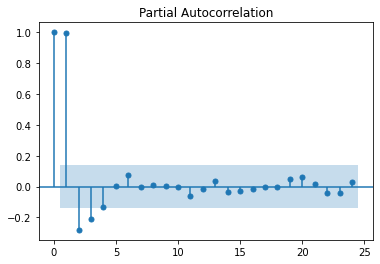

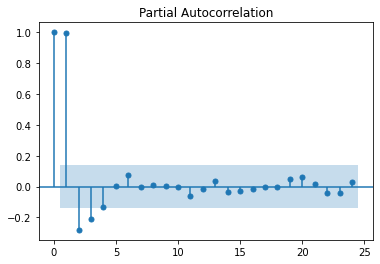

In [51]:
plot_pacf(x_arr)

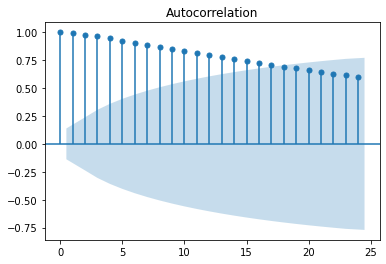

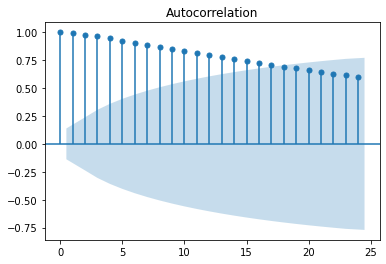

In [49]:
plot_acf(x_arr)

The PACF shows it's like AR(1), but the ACF did not taper to 0 suggesting a non-stationary series.

The ACF and PACF of the first differences showed the pattern of AR(1), so ARIMA(1,1,0) should be tried

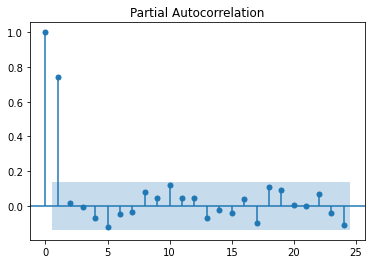

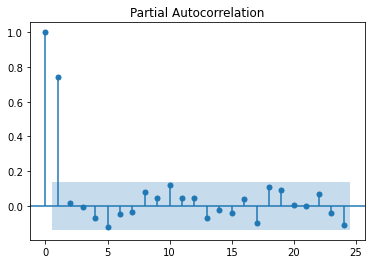

In [52]:
plot_pacf(np.diff(x_arr))

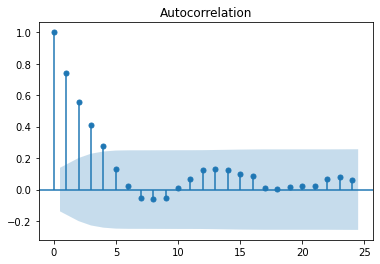

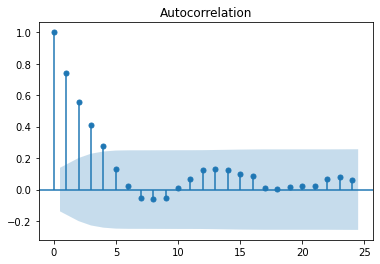

In [53]:
plot_acf(np.diff(x_arr))

In [55]:
ARIMA(x_arr, order=(1,1,0)).fit().summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32655D+00    |proj g|=  1.77969D-03

At iterate    5    f=  1.32653D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   0.000D+00   1.327D+00
  F =   1.3265300227145844     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  200
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -265.306
Method:                       css-mle   S.D. of innovations              0.910
Date:                Sat, 02 Jul 2022   AIC                            536.612
Time:                        21:38:22   BIC                            546.507
Sample:                             1   HQIC                           540.616
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2848      0.247      1.154      0.248      -0.199       0.769
ar.L1.D.y      0.7429      0.047     15.759      0.000       0.650       0.835
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3461           +0.0000j            1.3461            0.0000
-----------------------------------------------------------------------------
"""

#### step2: Filter the y series using the model for x

$$
x_t = 1.7 x_{t-1} - 0.7 x_{t-2} + \epsilon_t
$$

$$
y_t = 1.7 y_{t-1} - 0.7 y_{t-2}
$$

In [56]:
y_filter = np.zeros(201)
for i in range(2, 201):
    y_filter[i] = 1.7 * y_arr[i-1] - 0.7 * y_arr[i-2] 

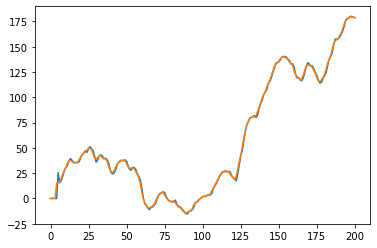

In [58]:
plt.plot(y_filter)
plt.plot(y_arr)